# Part 3: Machine Learning

In this section we will explore time-series algorithms and predict stock market movement for the next day/week

Benchmark: random generated numbers

# Importing Libraries

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from numpy import array
from importlib import reload # to reload modules if we made changes to them without restarting kernel
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier # for features importance

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 227 # native screen dpi for my computer

In [23]:
# ARIMA, SARIMA
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from pandas.plotting import autocorrelation_plot

In [24]:
# Tensorflow 2.0 includes Keras
import tensorflow.keras as keras
from tensorflow.python.keras.optimizer_v2 import rmsprop
from functools import partial
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, TimeDistributed, LSTM, Dense, Bidirectional, Dropout, ConvLSTM2D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Convolution1D, BatchNormalization, LeakyReLU
# Hyper Parameters Tuning with Bayesian Optimization (> pip install bayesian-optimization)
from bayes_opt import BayesianOptimization

from tensorflow.keras.utils import plot_model

In [25]:
import functions
import plotting

#import pandas_datareader as pdr
#aapl = pdr.get_data_yahoo('msft', '2000')

In [26]:
np.random.seed(66)

# Loading Data

Reading stocks' data and keeping it in dictionary **stocks**. `Date` feature becomes index

In [27]:
files = os.listdir('data/stocks')
stocks = {}
for file in files:
    # Include only csv files
    if file.split('.')[1] == 'csv':
        name = file.split('.')[0]
        stocks[name] = pd.read_csv('data/stocks/'+file, index_col='Date')
        stocks[name].index = pd.to_datetime(stocks[name].index)

# Baseline Model

Baseline model would serve as a benchmark for comparing with more complex models.

In [619]:
def baseline_model(stock):
    '''
    \n\n
    Input: Series or Array
    Returns: Accuracy Score
    Function generates random numbers [0,1] and compares them with true values
    \n\n
    '''
    baseline_predictions = np.random.randint(0, 2, len(stock))
    accuracy = accuracy_score(functions.binary(stock), baseline_predictions)
    return accuracy

In [620]:
baseline_model(stocks['tsla'].Return)

0.4960801393728223

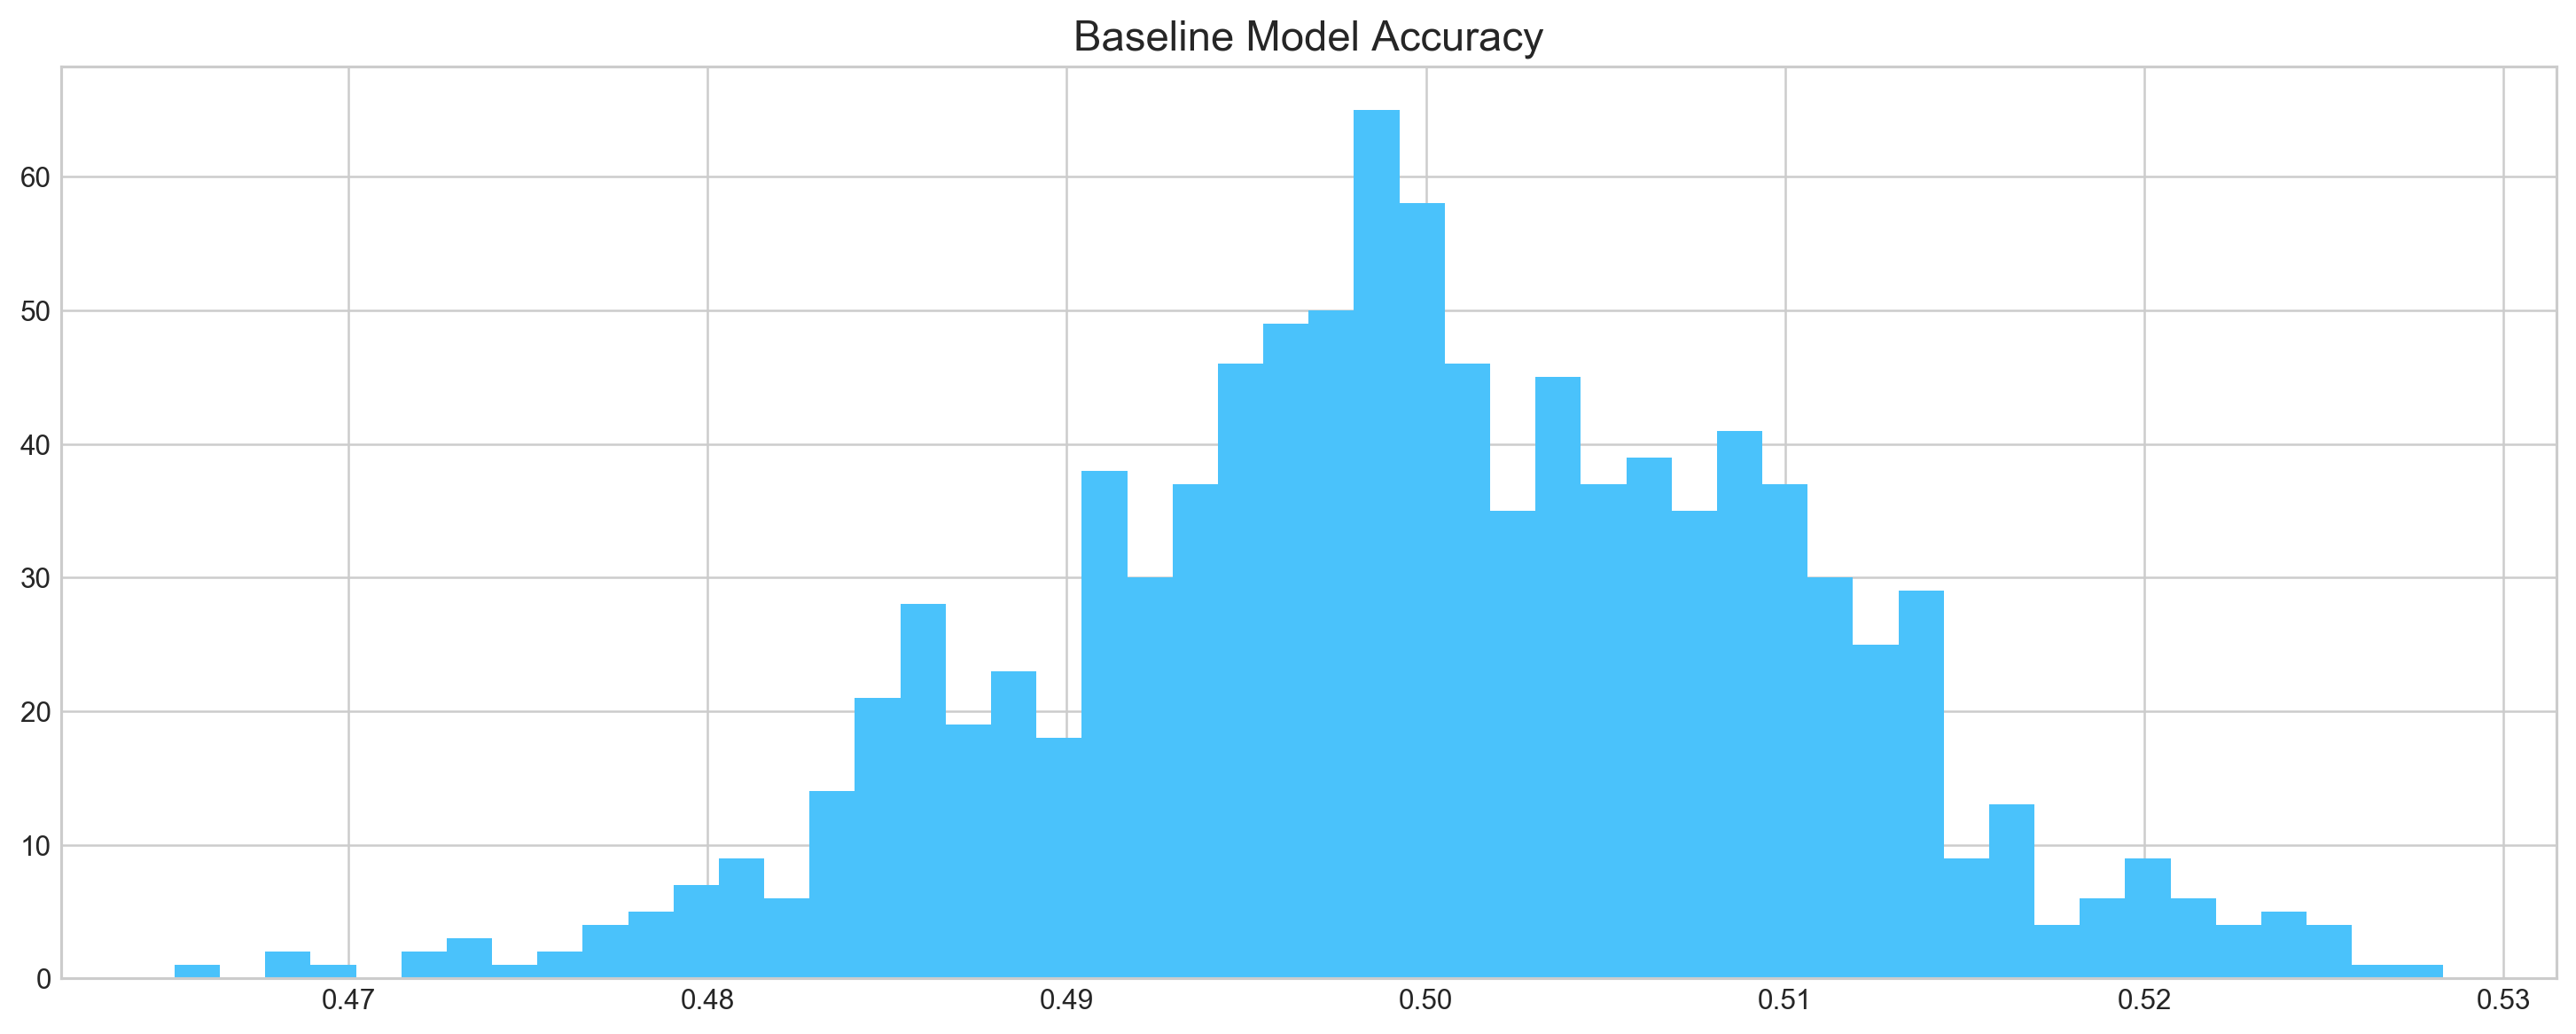

In [555]:
base_preds = []
for i in range(1000):
    base_preds.append(baseline_model(stocks['tsla'].Return))
    
plt.figure(figsize=(16,6))
plt.hist(base_preds, bins=50, facecolor='#4ac2fb')
plt.title('Baseline Model Accuracy', fontSize=15)
plt.show()

### Conclusion

Baseline model on average has 50% accuracy. We take this number as a guideline for our more complex models

# ARIMA

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

In [124]:
print('Tesla historical data contains {} entries'.format(stocks['tsla'].shape[0]))
stocks['tsla'][['Return']].head()

Tesla historical data contains 2296 entries


,Return
Date,
2010-07-28,0.008
2010-07-29,-0.020
2010-07-30,-0.013
2010-08-02,0.020
2010-08-03,0.045


In [405]:
# ARIMA orders
orders = [(1,1,1),(1,1,0),(1,0,1),(0,1,1),(1,0,0),(0,1,0),(0,0,1),(0,0,0)]

# Splitting into train and test sets
train = list(stocks['tsla']['Return'][:2000].values)
test = list(stocks['tsla']['Return'][2000:2010].values)

all_predictions = {}

for order in orders:
    
    try:
        # History will contain original train set, 
        # but with each iteration we will add one datapoint
        # from the test set as we continue prediction
        history = train.copy()
        order_predictions = []
        
        for i in range(len(test)):
            
            model = ARIMA(history, order=order) # defining ARIMA model
            model_fit = model.fit(disp=0) # fitting model
            y_hat = model_fit.forecast() # predicting 'return'
            order_predictions.append(y_hat[0][0]) # first element ([0][0]) is a prediction
            history.append(test[i]) # simply adding following day 'return' value to the model    
            print('Prediction: {} of {}'.format(i+1,len(test)), end='\r')
        
        accuracy = accuracy_score( 
            functions.binary(test), 
            functions.binary(order_predictions) 
        )
        
        print('                             ', end='\r')
        print('{} - {:.1f}% accuracy'.format(order, round(accuracy, 2)*100), end='\n')
        all_predictions[order] = order_predictions
    
    except:
        print(order, '<== Wrong Order', end='\n')
        pass

(1, 1, 1) - 50.0% accuracy   
(1, 1, 0) - 40.0% accuracy   
(1, 0, 1) <== Wrong Order
(0, 1, 1) - 50.0% accuracy   
(1, 0, 0) - 50.0% accuracy   
(0, 1, 0) - 10.0% accuracy   
(0, 0, 1) - 50.0% accuracy   
(0, 0, 0) - 50.0% accuracy   


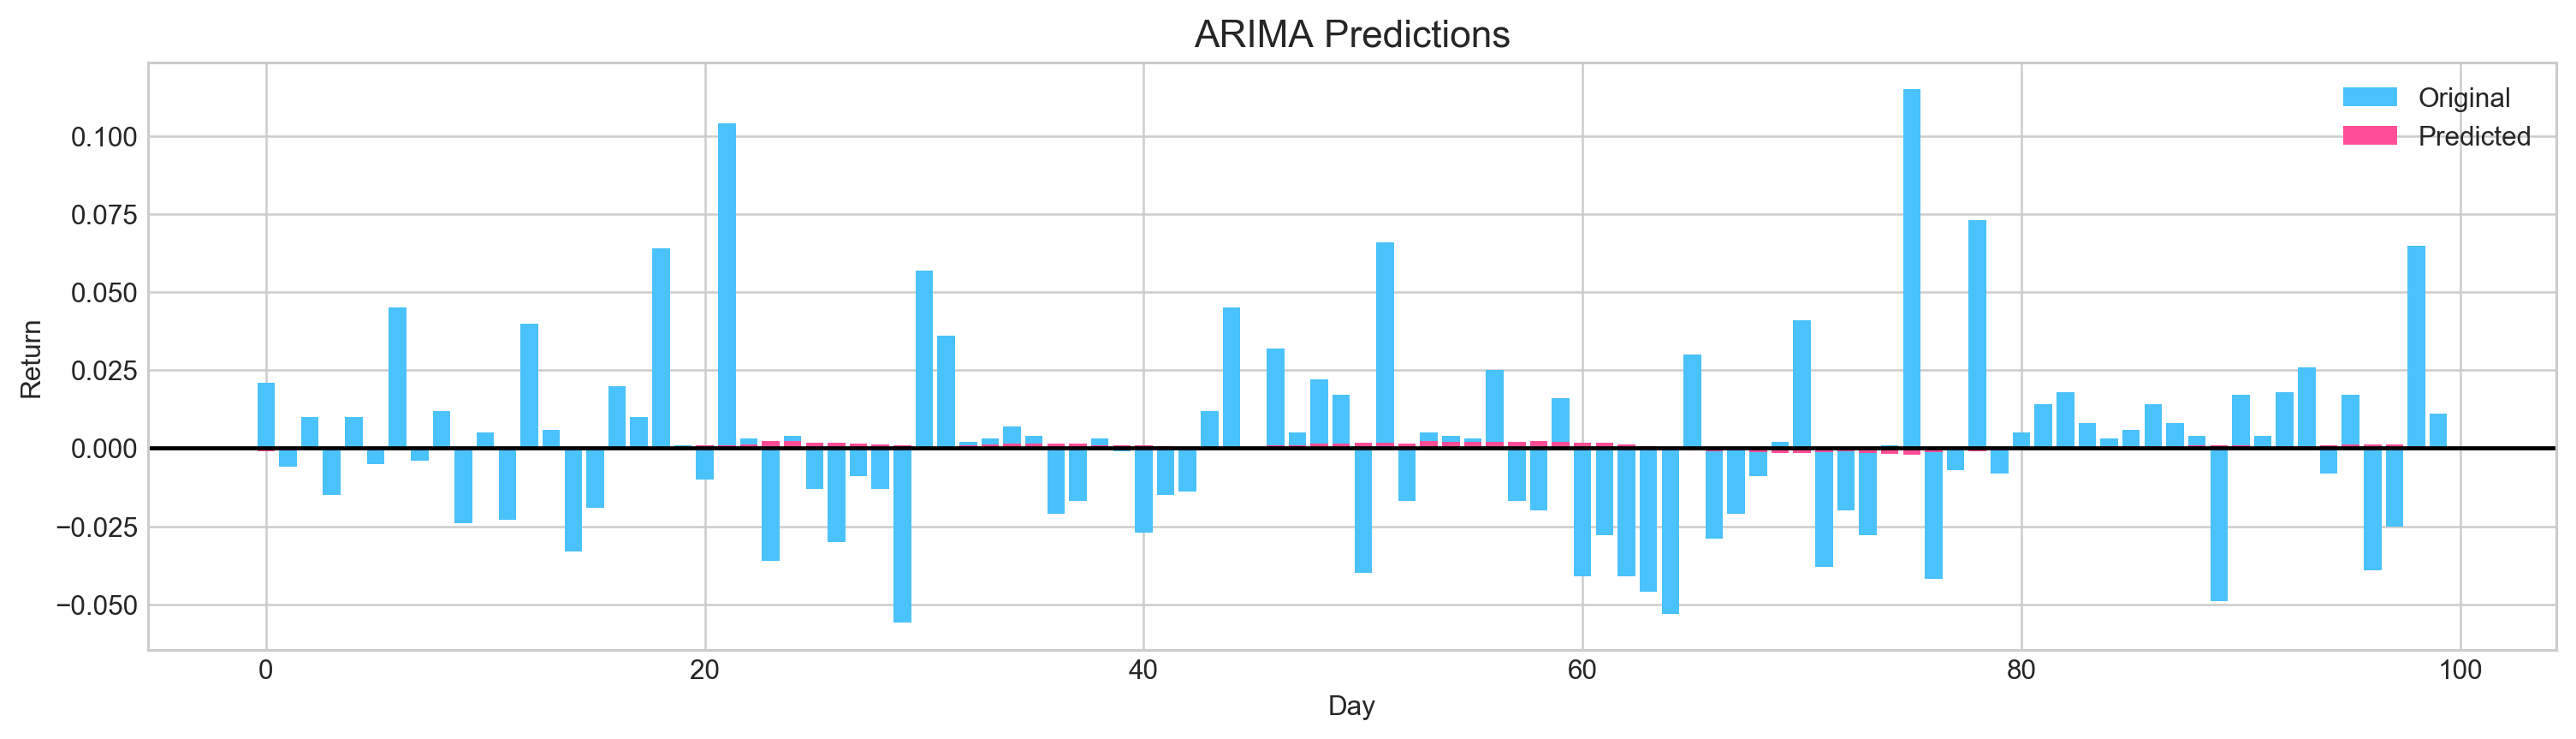

In [365]:
# Plotting Results
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,4))
plt.bar(range(100), stocks['tsla'][2000:2100].reset_index().Return, color="#4ac2fb", label='Original')
plt.bar(range(100), all_predictions[(1,1,1)], color="#ff4e97", label='Predicted')
plt.axhline(0, color='k')
plt.legend()
plt.title('ARIMA Predictions', fontSize=14)
plt.xlabel('Day')
plt.ylabel('Return')
plt.show()


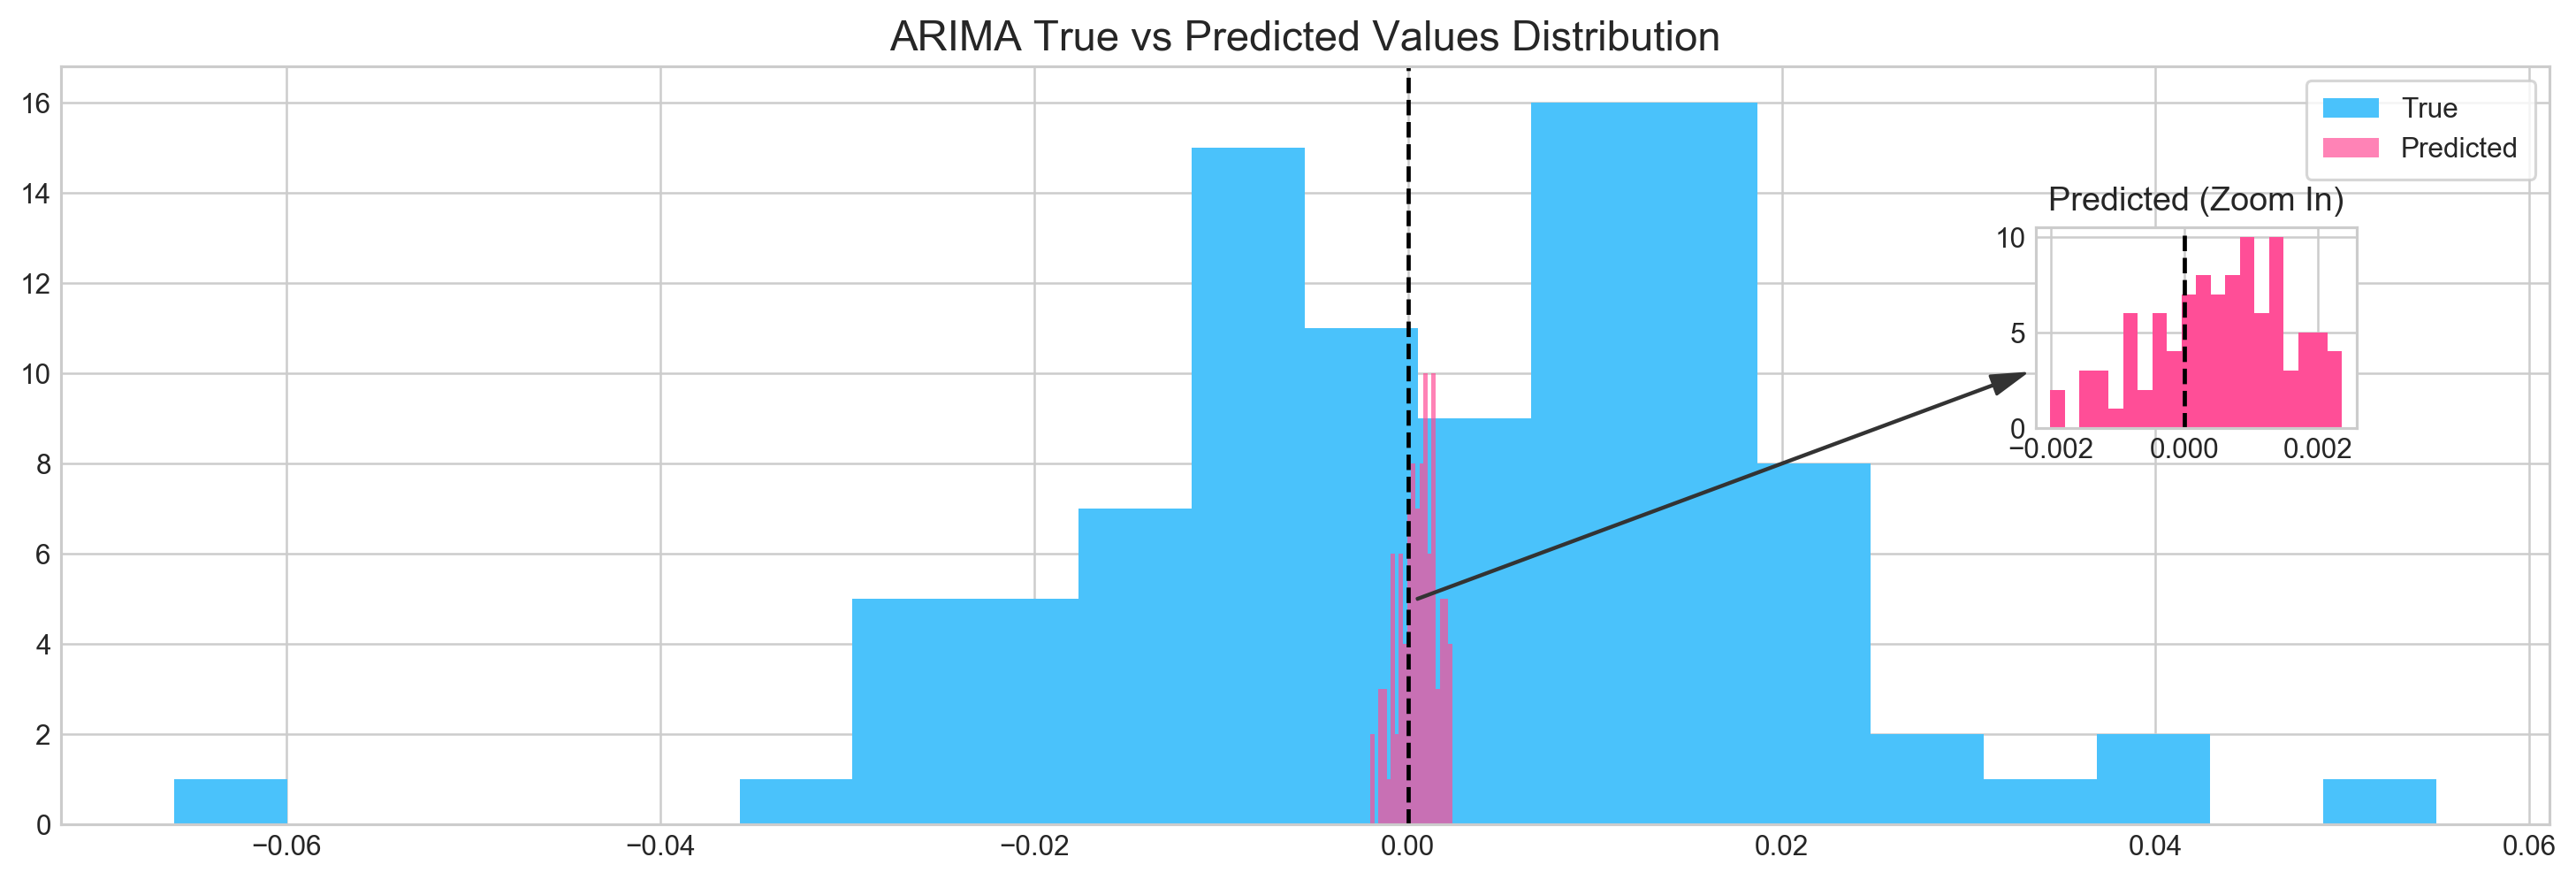

In [364]:
plt.figure(figsize=(16,5))
plt.hist(stocks['aapl'][2000:2100].reset_index().Return, bins=20, label='True', facecolor='#4ac2fb')
plt.hist(all_predictions[(1,1,1)], bins=20, label='Predicted', facecolor='#ff4e97', alpha=.7)
plt.axvline(0, c='k', ls='--')
plt.title('ARIMA True vs Predicted Values Distribution', fontSize=15)
plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
plt.annotate('',
             xy=(0.033, 10), 
             xytext=(0.0005, 5), 
             fontsize=10, 
             arrowprops={'width':0.4,'headwidth':7,'color':'#333333'}
            )

plt.axes([.74, .52, .1, .2])
plt.hist(all_predictions[(1,1,1)], bins=20, facecolor='#ff4e97')
plt.axvline(0, c='k', ls='--')

plt.title('Predicted (Zoom In)')


plt.show()

### Interpreting Results

In [382]:
test = functions.binary(stocks['aapl'][2000:2100].reset_index().Return)
train = functions.binary(all_predictions[(1,1,1)])
tn, fp, fn, tp = confusion_matrix(test, train).ravel()
accuracy = accuracy_score(test, train)

print("True positive and Negative: {}".format((tp + tn)))
print("False Positive and Negative: {}".format((fp + fn)))
print("Accuracy: {:.1f}%".format(accuracy*100))

True positive and Negative: 56
False Positive and Negative: 44
Accuracy: 56.0%


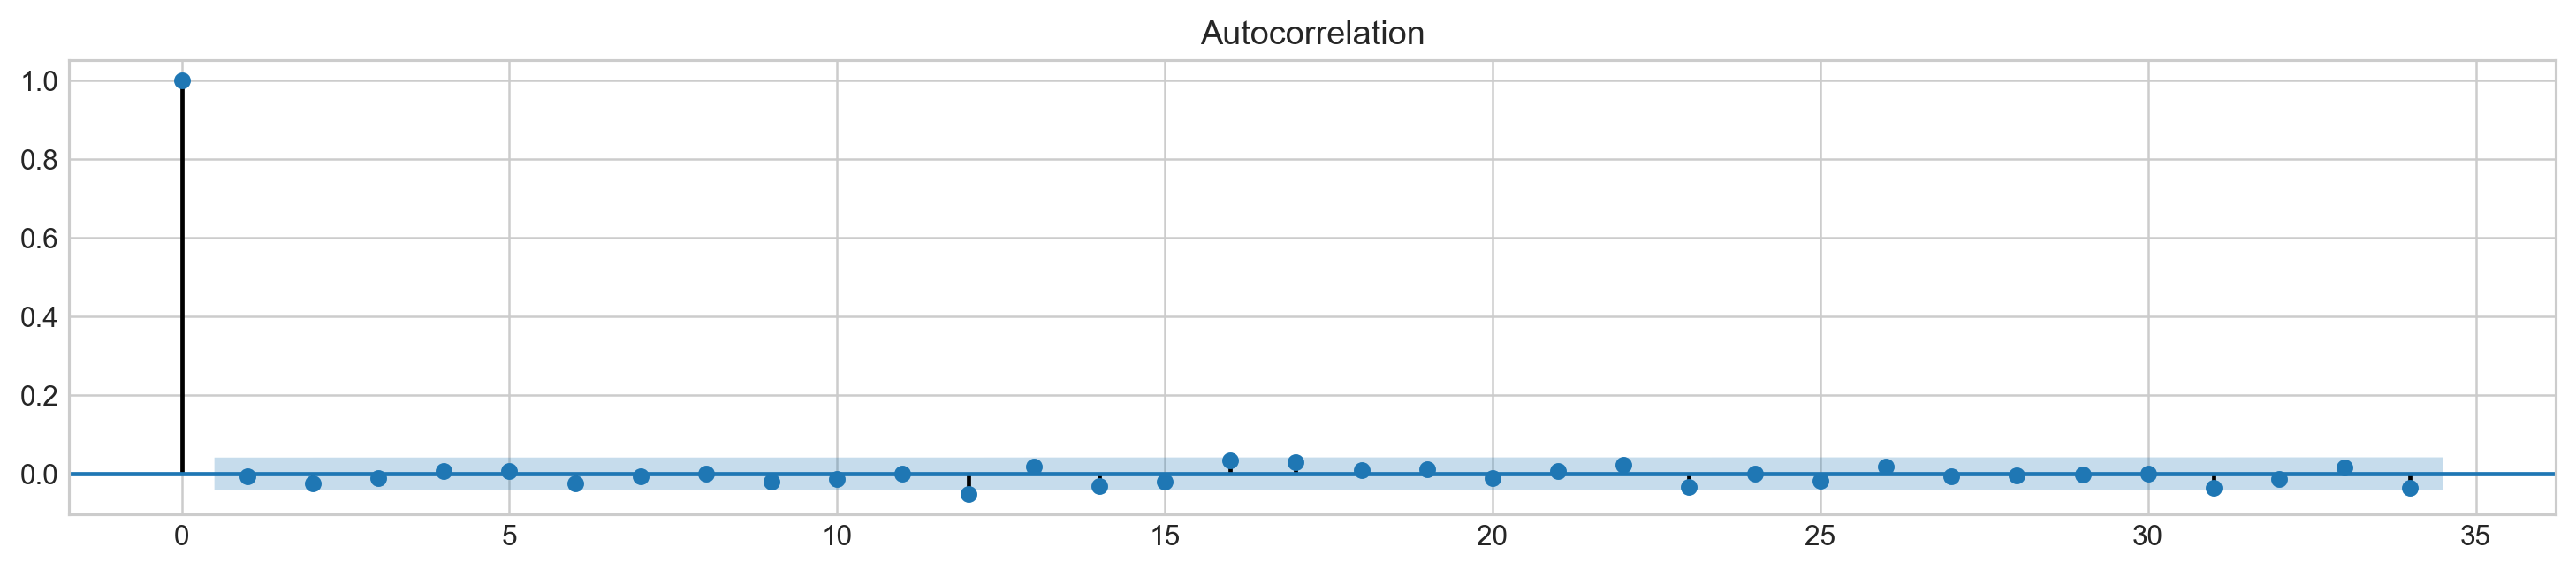

In [602]:
plt.rcParams['figure.figsize'] = (16,3)
plot_acf(stocks['tsla'].Return)
plt.show()

## Adding Sentiment to Tesla Historical Data

In [42]:
tesla_headlines = pd.read_csv('data/tesla_headlines.csv', index_col='Date')

In [85]:
tesla = stocks['tsla'].join(tesla_headlines.groupby('Date').mean().Sentiment)

In [86]:
tesla.fillna(0, inplace=True)

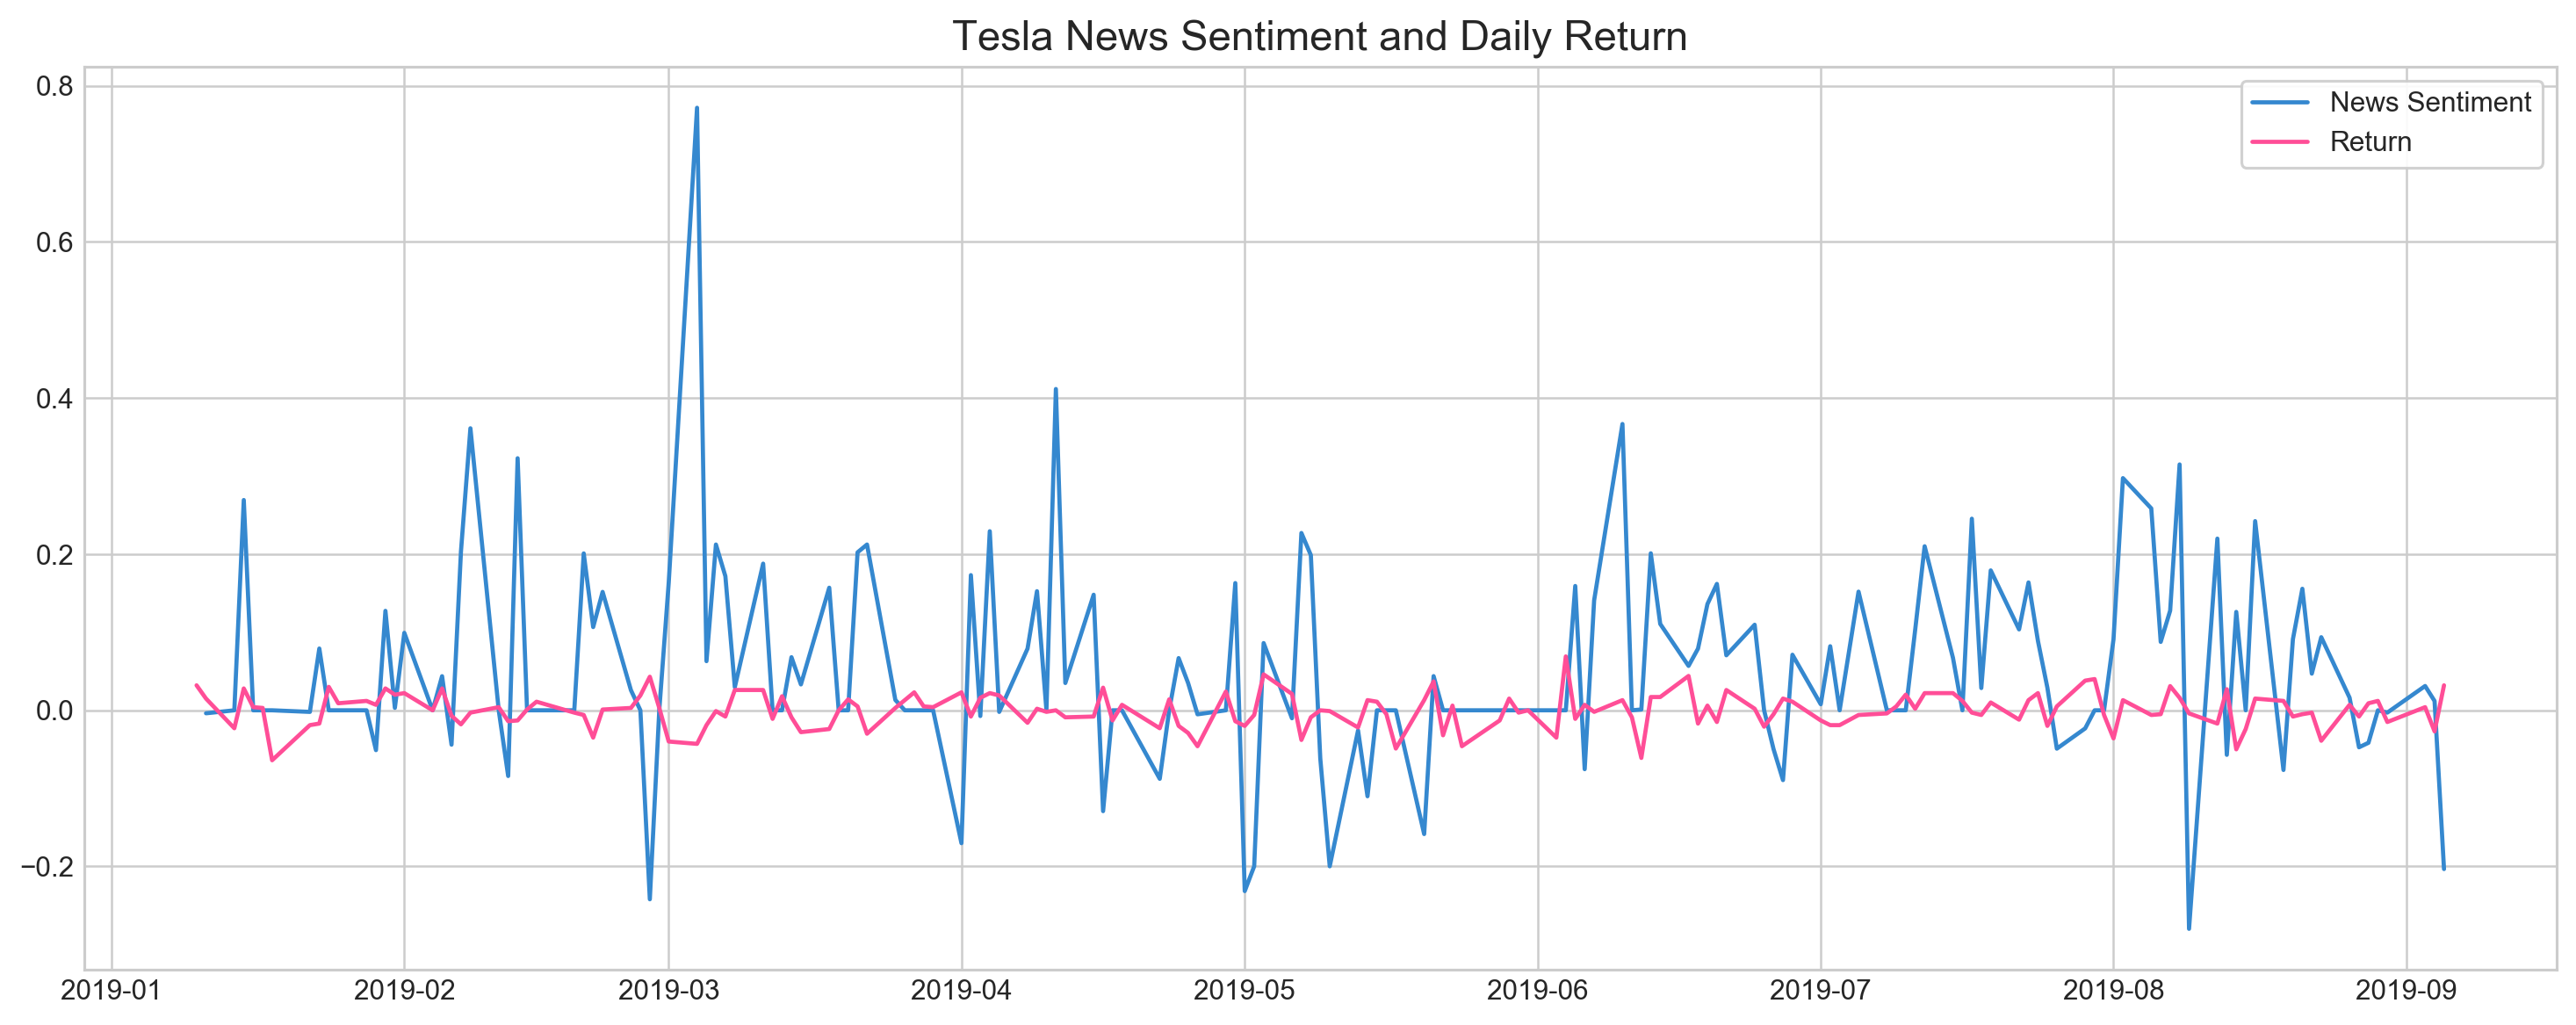

In [125]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,6))
plt.plot(tesla.loc['2019-01-10':'2019-09-05'].Sentiment.shift(1), c='#3588cf', label='News Sentiment')
plt.plot(tesla.loc['2019-01-10':'2019-09-05'].Return, c='#ff4e97', label='Return')
plt.legend(frameon=True, fancybox=True, framealpha=.9, loc=1)
plt.title('Tesla News Sentiment and Daily Return', fontSize=15)
plt.show()

In [127]:
pd.DataFrame({
    'Sentiment': tesla.loc['2019-01-10':'2019-09-05'].Sentiment.shift(1), 
    'Return': tesla.loc['2019-01-10':'2019-09-05'].Return}).corr()

,Sentiment,Return
Sentiment,1.000000,-0.139348
Return,-0.139348,1.000000


### Conclusion

# Features selection with XGBoost

In [454]:
scaled_tsla = functions.scale(stocks['tsla'], scale=(0,1))

In [455]:
X = scaled_tsla[:-1]
y = stocks['tsla'].Return.shift(-1)[:-1]

In [456]:
len(y)

2295

In [462]:
xgb = XGBClassifier()
xgb.fit(X[1000:], y[1000:])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

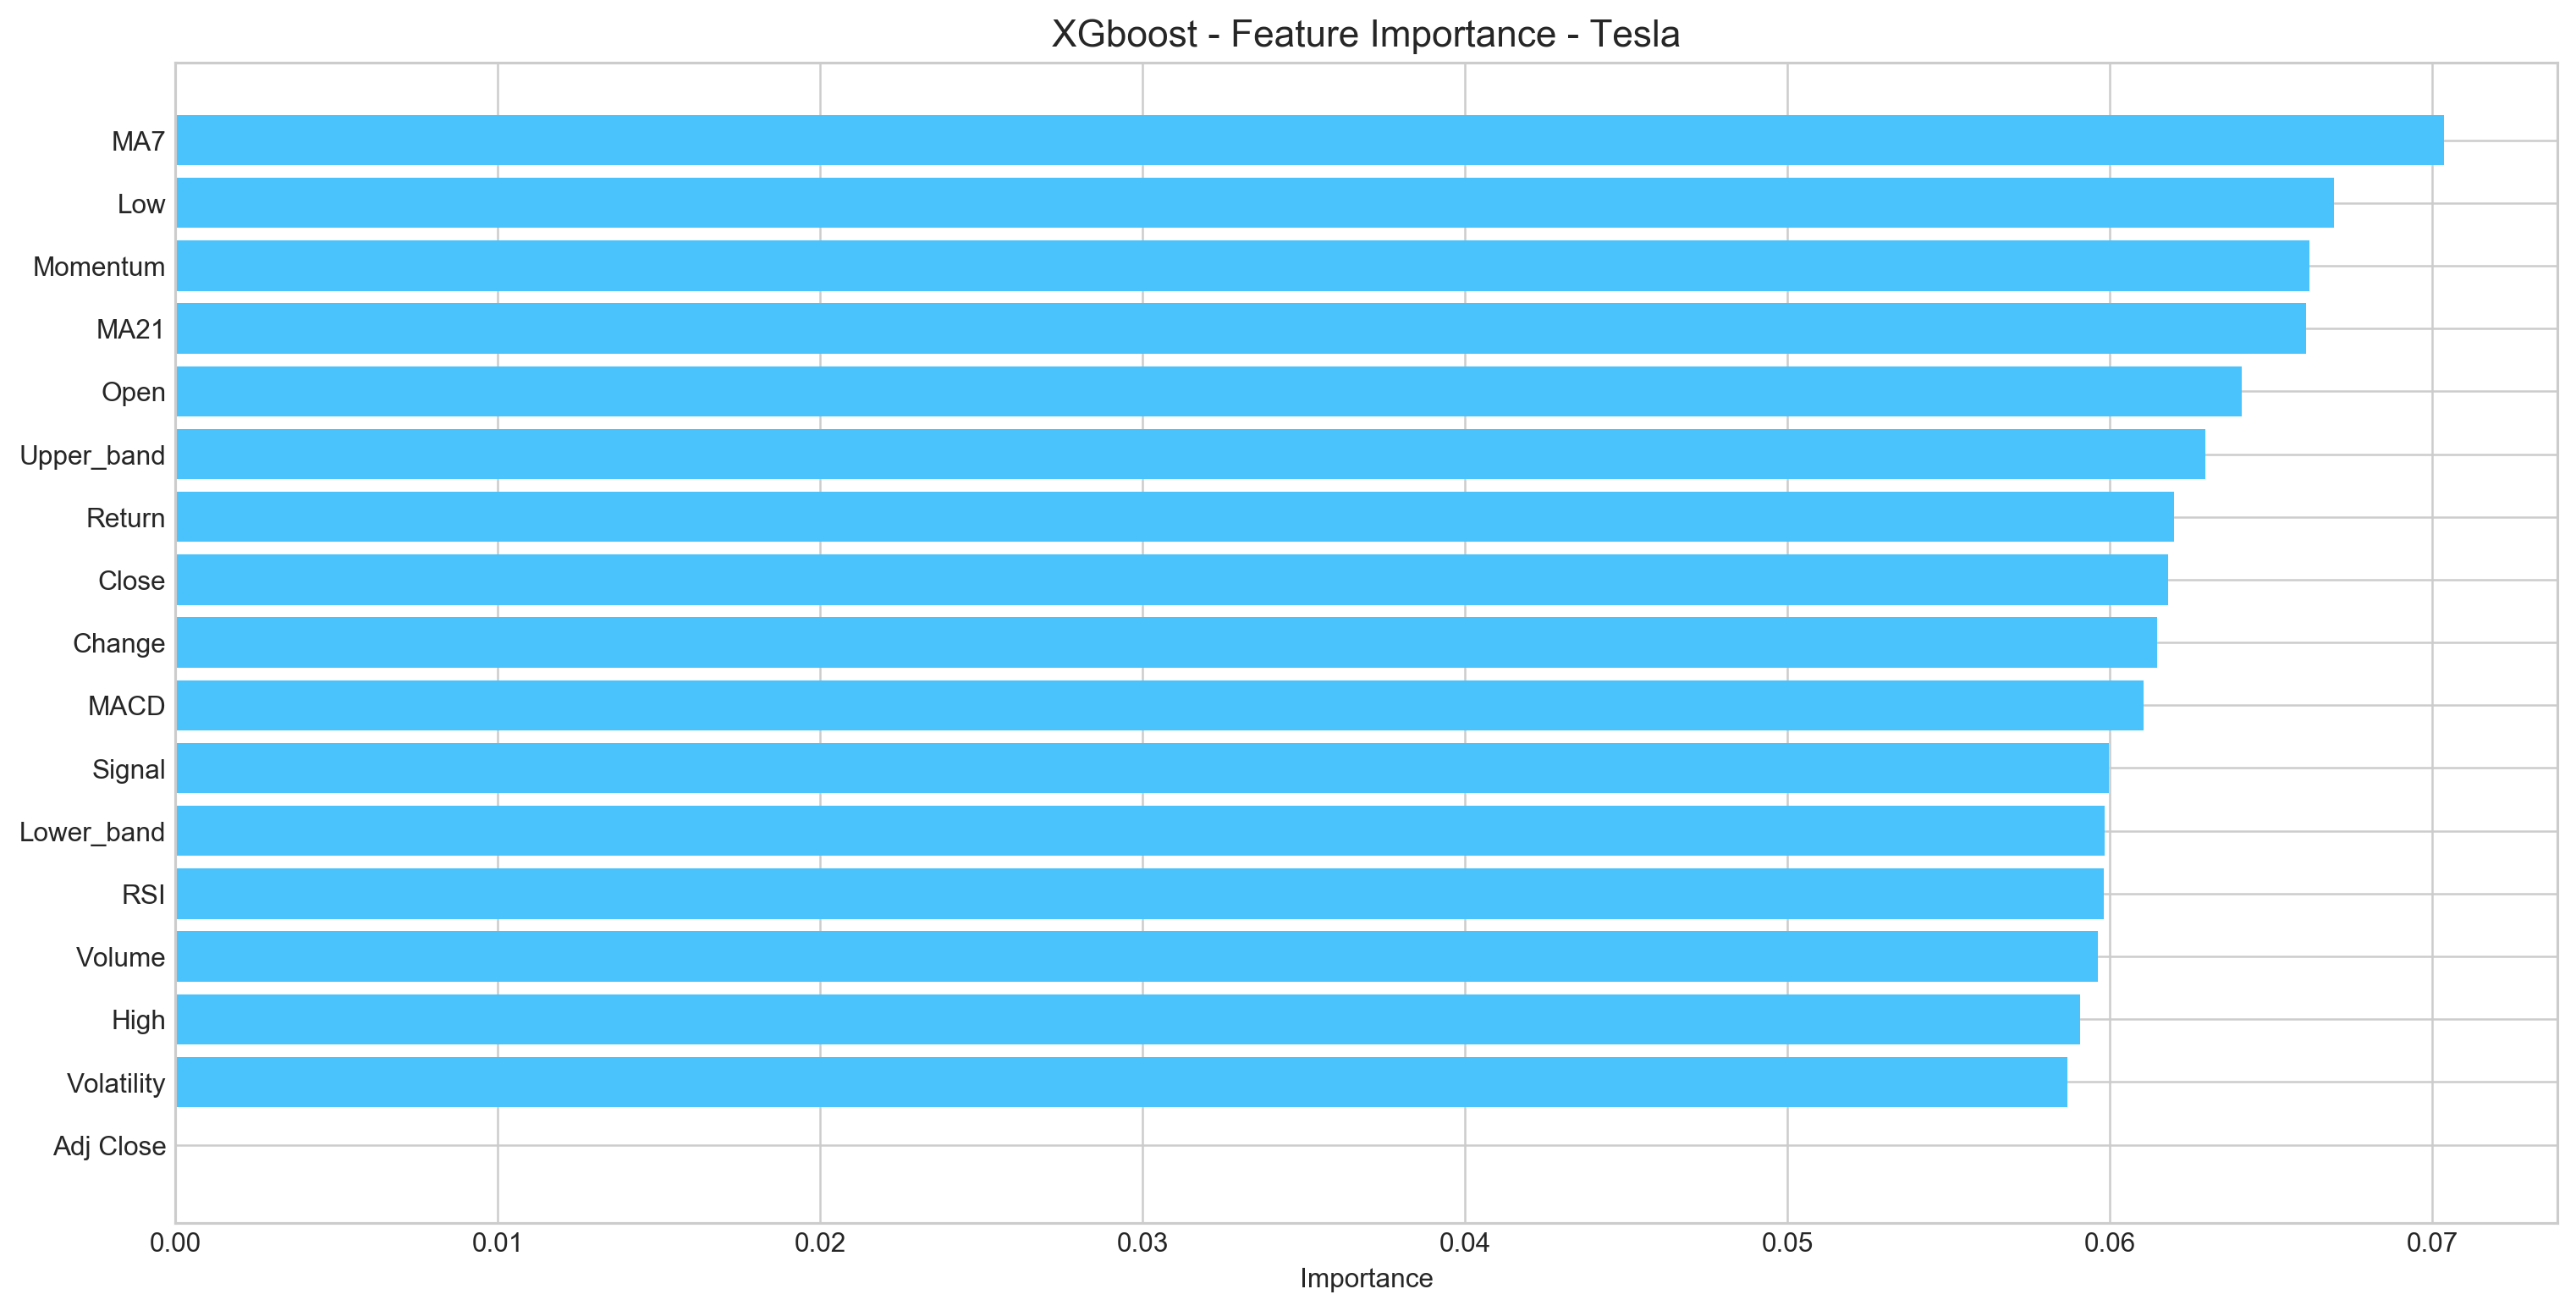

In [463]:
important_features = pd.DataFrame({
                                    'Feature': X.columns, 
                                    'Importance': xgb.feature_importances_}) \
                                    .sort_values('Importance', ascending=True)

plt.figure(figsize=(16,8))
plt.style.use('seaborn-whitegrid')
plt.barh(important_features.Feature, important_features.Importance, color="#4ac2fb")
plt.title('XGboost - Feature Importance - Tesla', fontSize=14)
plt.xlabel('Importance')
plt.show()

# Deep Neural Networks

In [ ]:
n_steps = 21
scaled_tsla = functions.scale(stocks['tsla'], scale=(0,1))

X_train, 
y_train, 
X_test, 
y_test = functions.split_sequences(
                        
    scaled_tsla.to_numpy()[:-1], 
    stocks['tsla'].Return.shift(-1).to_numpy()[:-1], 
    n_steps, 
    split=True, 
    ratio=0.8
)

## LSTM Network

In [ ]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=20, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.legend(loc=1)
plt.title('LSTM - Training Process')
plt.show()

In [ ]:
pred, y_true, y_pred = functions.evaluation(
                    X_test, y_test, model, random=False, n_preds=100, 
                    show_graph=True)

## Convolutional Network

In [ ]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()

model.add(Conv1D(filters=20, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(5, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [ ]:
model.summary()

## Combined Stocks Data

In [2409]:
all_stocks = pd.concat(stocks,ignore_index=True)

In [2410]:
scaled_all = functions.scale(all_df, scale=(0,1))

n_steps = 21
X_train, y_train, X_test, y_test = functions.split_sequences(
                        scaled_all.to_numpy()[:-1], 
                        all_stocks.Return.shift(-1).to_numpy()[:-1], n_steps, split=True, ratio=0.8)

In [2412]:
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()
model.add(Conv1D(filters=500, kernel_size=10, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=10))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

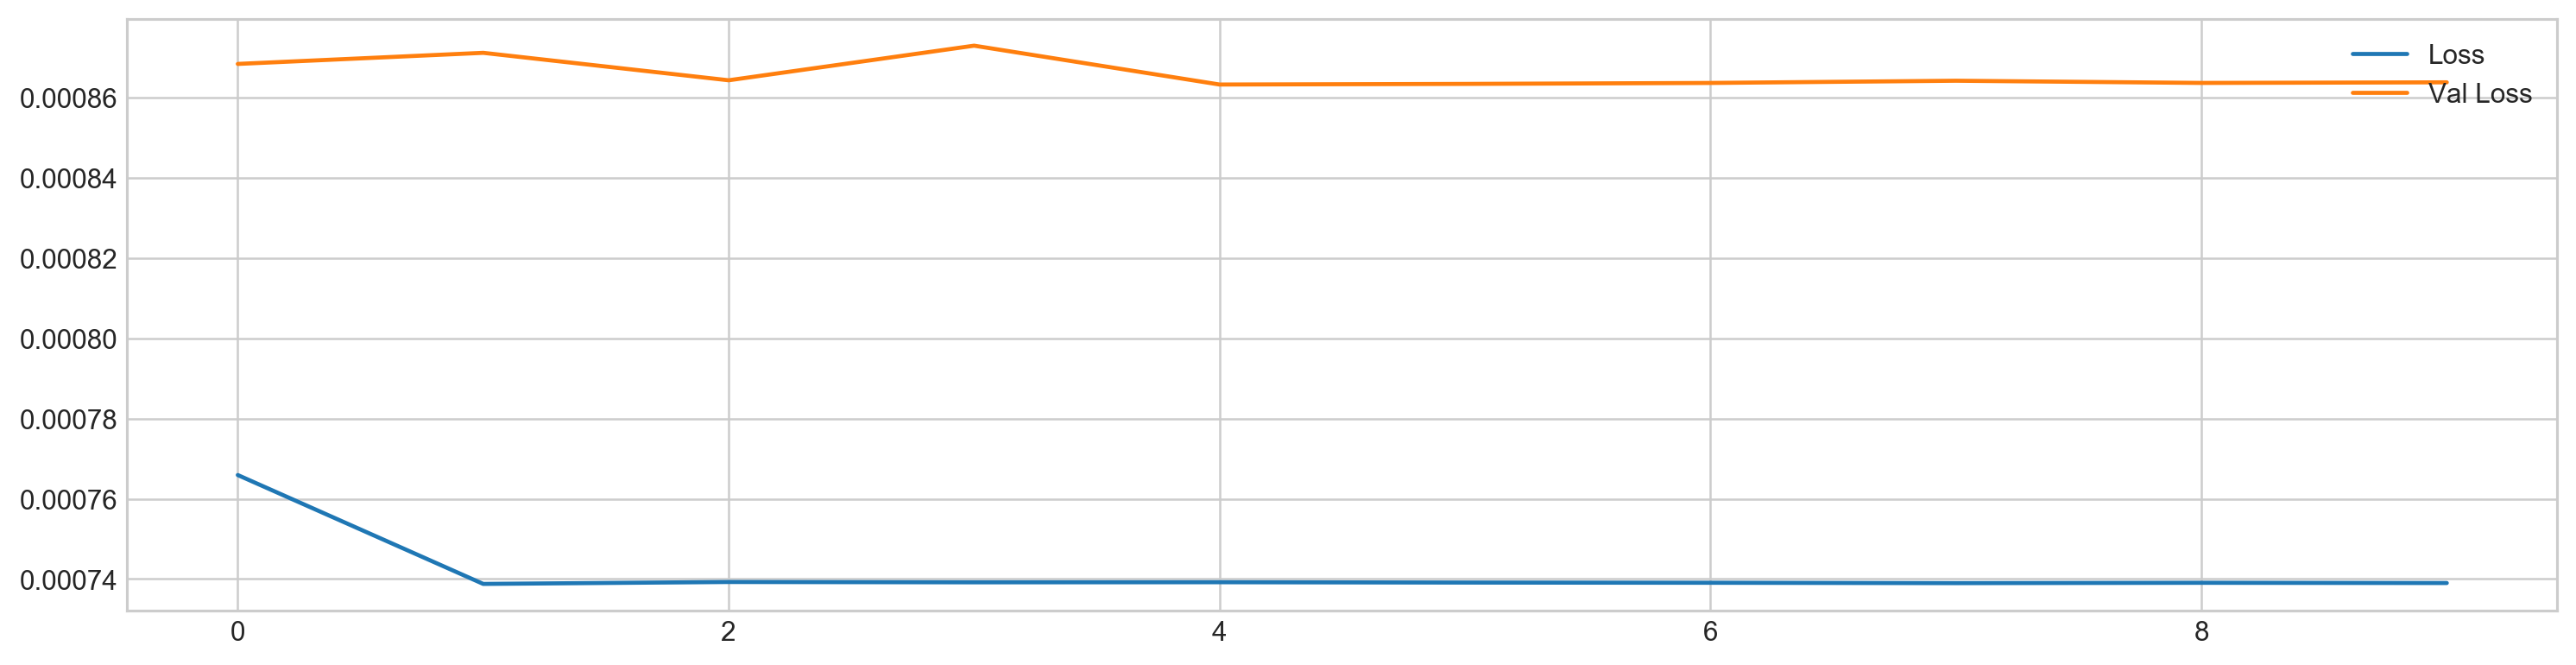

In [2414]:
model.fit(X_train, y_train, epochs=10, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.legend(loc=1)
plt.show()

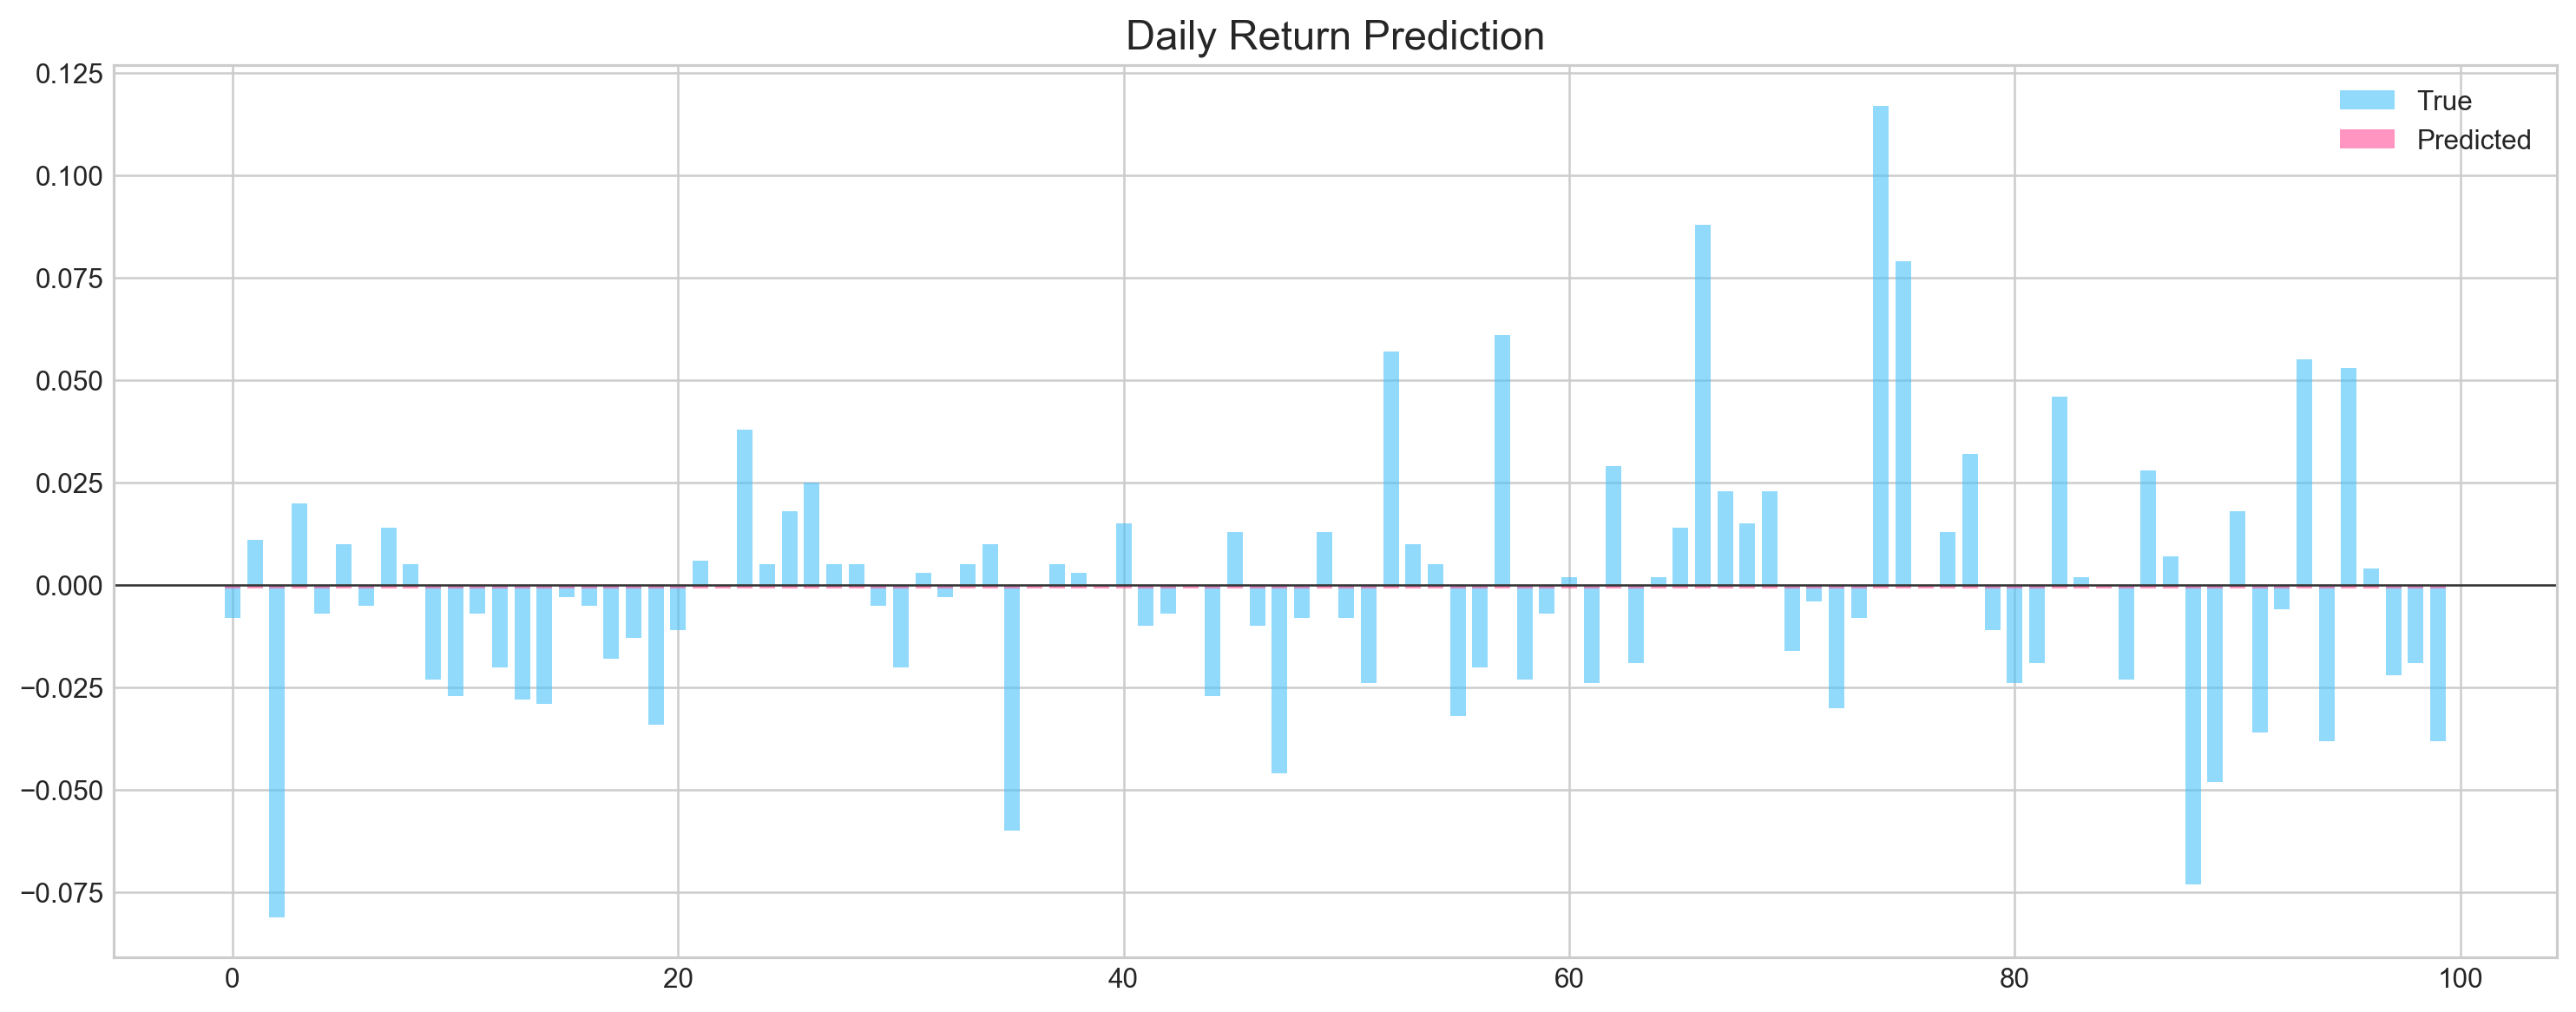

MSE: 0.0008956624945603114
Accuracy: 50%


In [2415]:
# TEST
pred, y_true, y_pred = functions.evaluation(
                    X_test, y_test, model, random=False, n_preds=100, 
                    show_graph=True)

## Bayesian Optimization

In [493]:
def create_model(d1, d2, filters, pool, kernel):
    keras.backend.clear_session()
        
    d1 = int(d1)
    d2 = int(d2)
    filters = int(filters)
    kernel = int(kernel)
    pool = int(pool)
    
    n_steps = X_train.shape[1]
    n_features = X_train.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=pool))
    model.add(Flatten())
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(d2, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    model.fit(X_train, y_train, epochs=4, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

In [534]:
def bayesian_optimization(model, X, y):    

    pbounds = {
        'filters': (1, 10), 
        'd1': (160, 250), 
        'd2': (10, 40), 
        'kernel': (2,10), 
        'pool': (2, 10)
    }

    optimizer = BayesianOptimization(
        f = create_model,
        pbounds = pbounds,
        random_state = 1,
        verbose = 2
    )
    optimizer.maximize(init_points=5, n_iter=5)
    print(optimizer.max)

## Finding Patterns

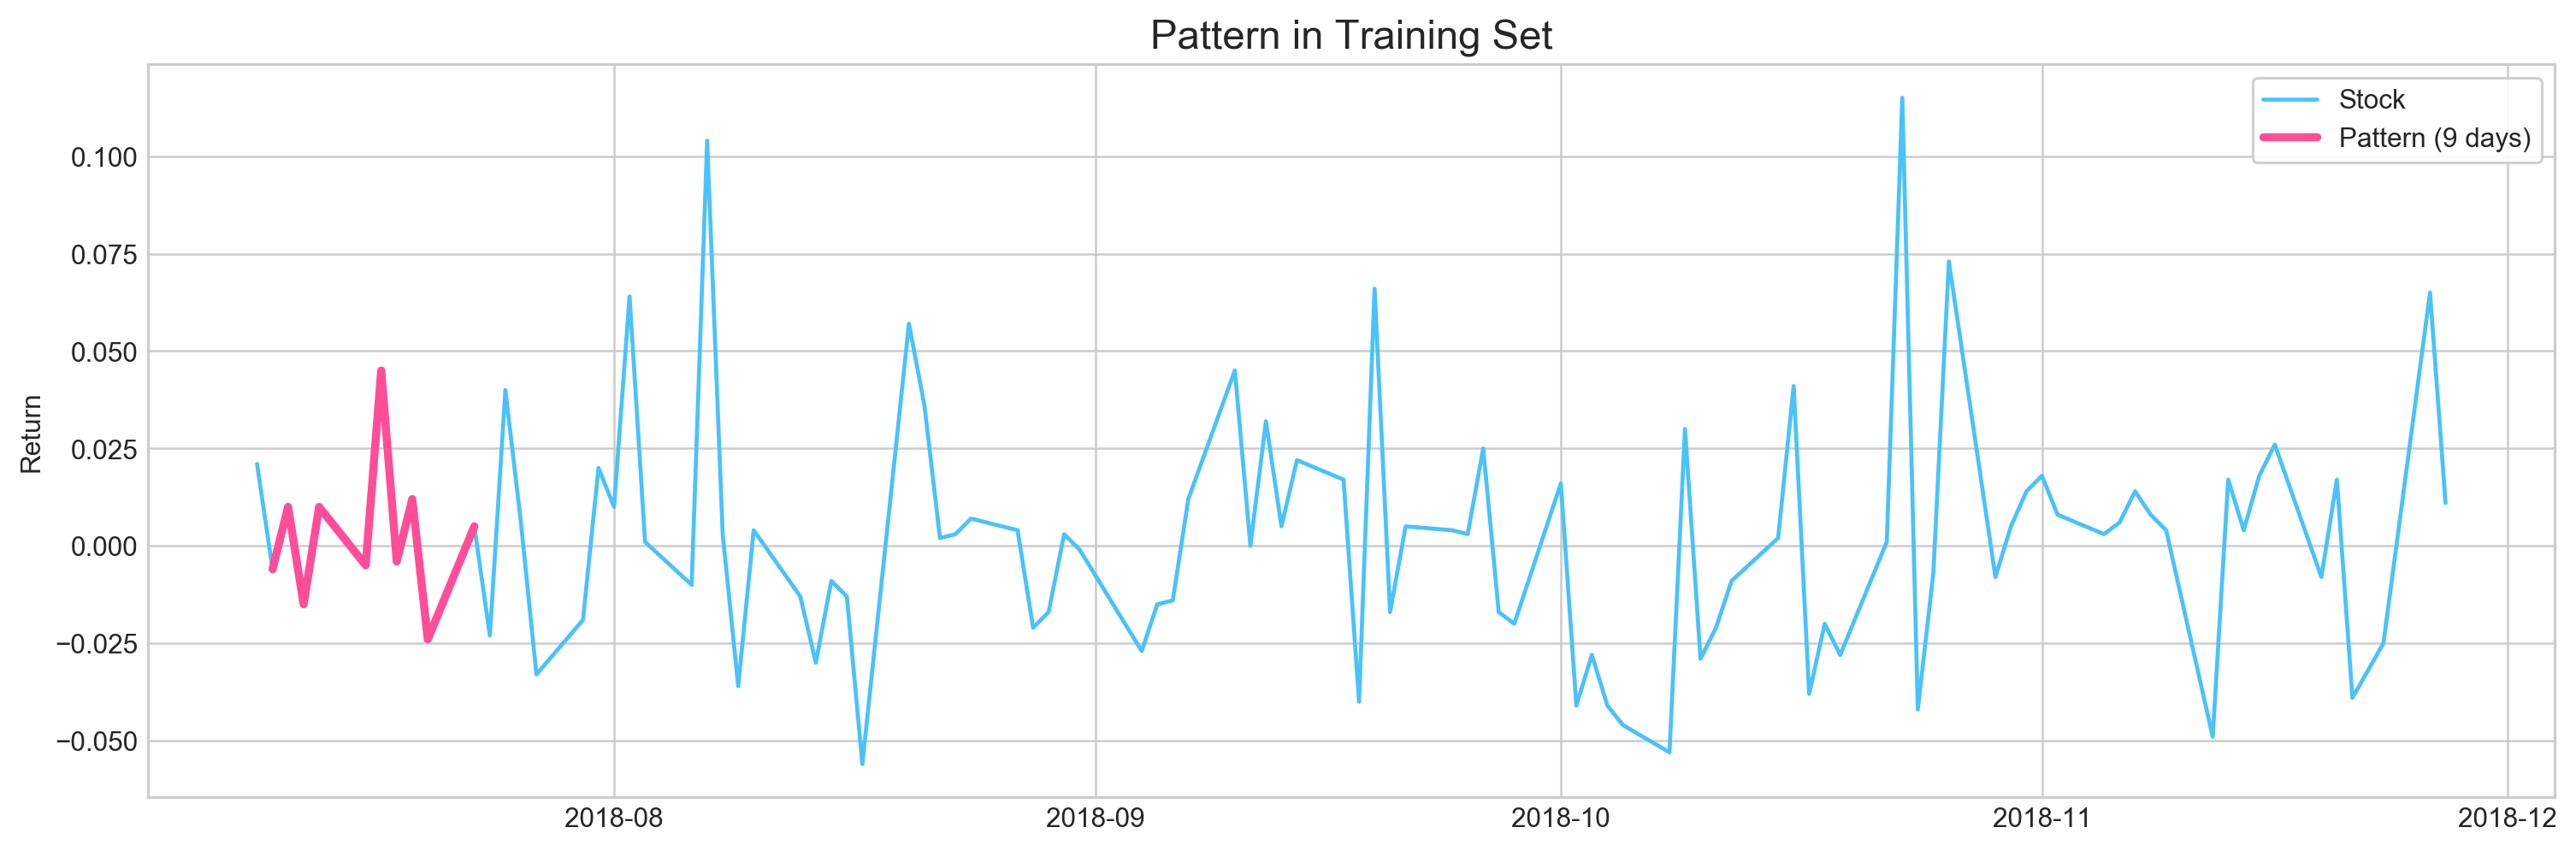

In [508]:
plt.figure(figsize=(16,5))
plt.plot(stocks['tsla'][2000:2100].Return, label='Stock', c='#4ac2fb')
plt.plot(stocks['tsla'][2001:2011].Return, lw=3, label='Pattern (9 days)', c='#ff4e97')
plt.legend(frameon=True, fancybox=True, framealpha=.9, loc=1)
plt.title('Pattern in Training Set', fontSize=15)
plt.ylabel('Return')
plt.show()

In [550]:
binary_return = functions.binary(stocks['tsla'].Return.values)

binary_train = binary_return[:2000]
binary_test = binary_return[2000:]

step = 9 # length of the pattern we're trying to find (ex.: [0,0,1,0,1,1,0,1,0])
check_step = step + 1 # value we're trying to predict (value that goes after pattern [0 or 1])
total_predictions = []

# Here we loop through test set (or part of it)
# and pick a pattern with length 'step'
for i in range(10):    
    if i + check_step >= len(binary_test):
        break    
    found_patterns = []    
    sample = binary_test[i:i+step]
    sample_check = binary_test[i+check_step]
    
    # Looking for patterns in training set
    # that matches with pattern from testing set
    for j in range(len(binary_train)-check_step):                          
        if accuracy_score( binary_train[j:j+step], sample ) == 1.0:
            found_patterns.append(i)
            
    p = []
    prediction = None
    if len(found_patterns) != 0:
        for k in found_patterns:
            p.append( binary_train[k+check_step] )
        
        prediction = sum(p)/len(p)
        if sample_check == prediction:
            total_predictions.append(1)
        else:
            total_predictions.append(0)
    
accuracy = sum(total_predictions)/len(total_predictions)
print('Accuracy:', accuracy)

Accuracy: 0.7


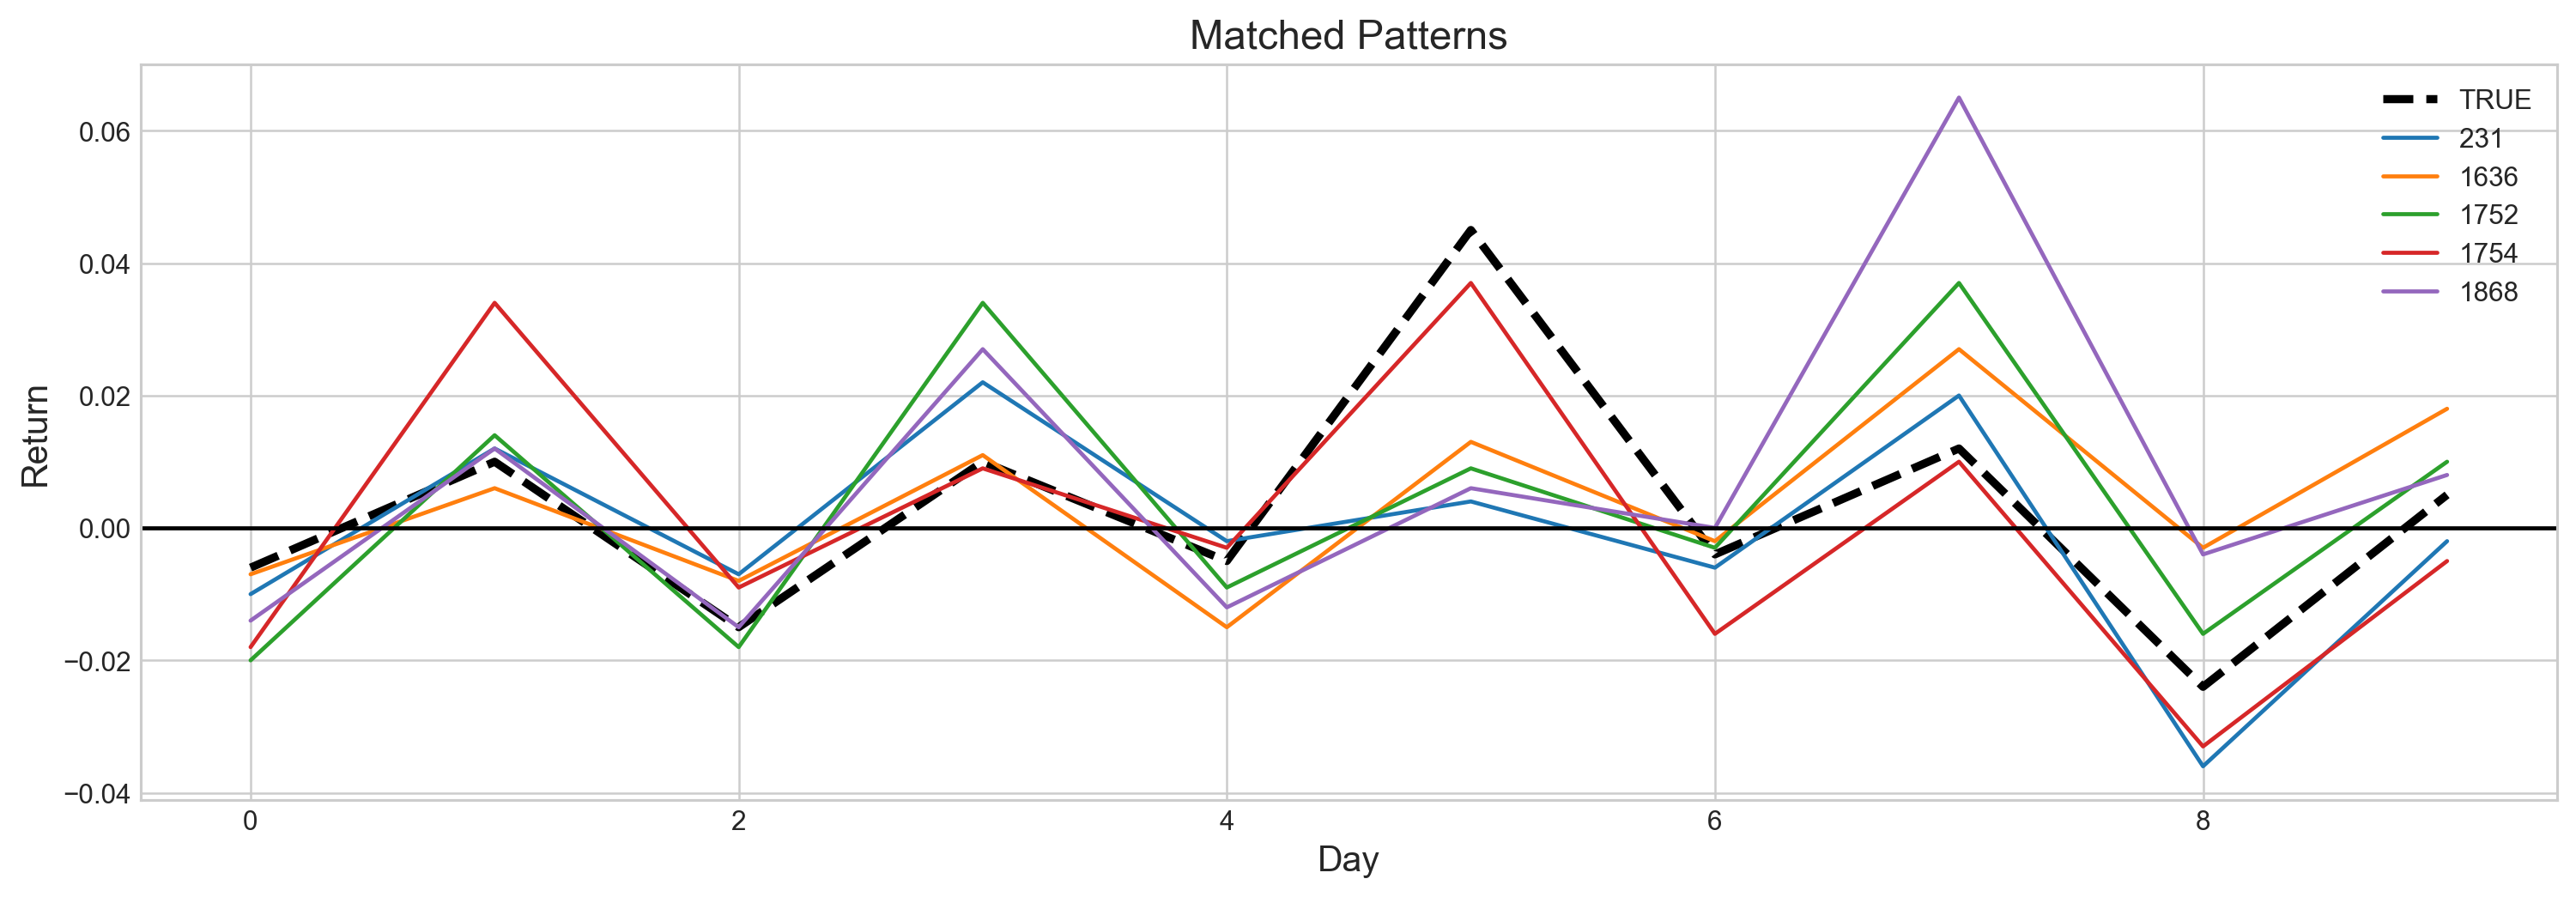

In [544]:
start = 1
window = 9
a = []

sample = binary_test[start:start+window]
for i in range(len(binary_train)-window):
    if accuracy_score(binary_train[i:i+window], sample) == 1.0: a.append(i)

plt.figure(figsize=(16,5))
plt.plot(stocks['tsla'][2000+start:start+2010].Return.values, label='TRUE', ls='--', lw=3, c='k')
[plt.plot(stocks['tsla'].Return[i:i+10].values, label=i) for i in a]
plt.axhline(0, c='k')
plt.title('Matched Patterns', fontSize=15)
plt.xlabel('Day', fontSize=13)
plt.ylabel('Return', fontSize=13)
plt.legend()
plt.show()

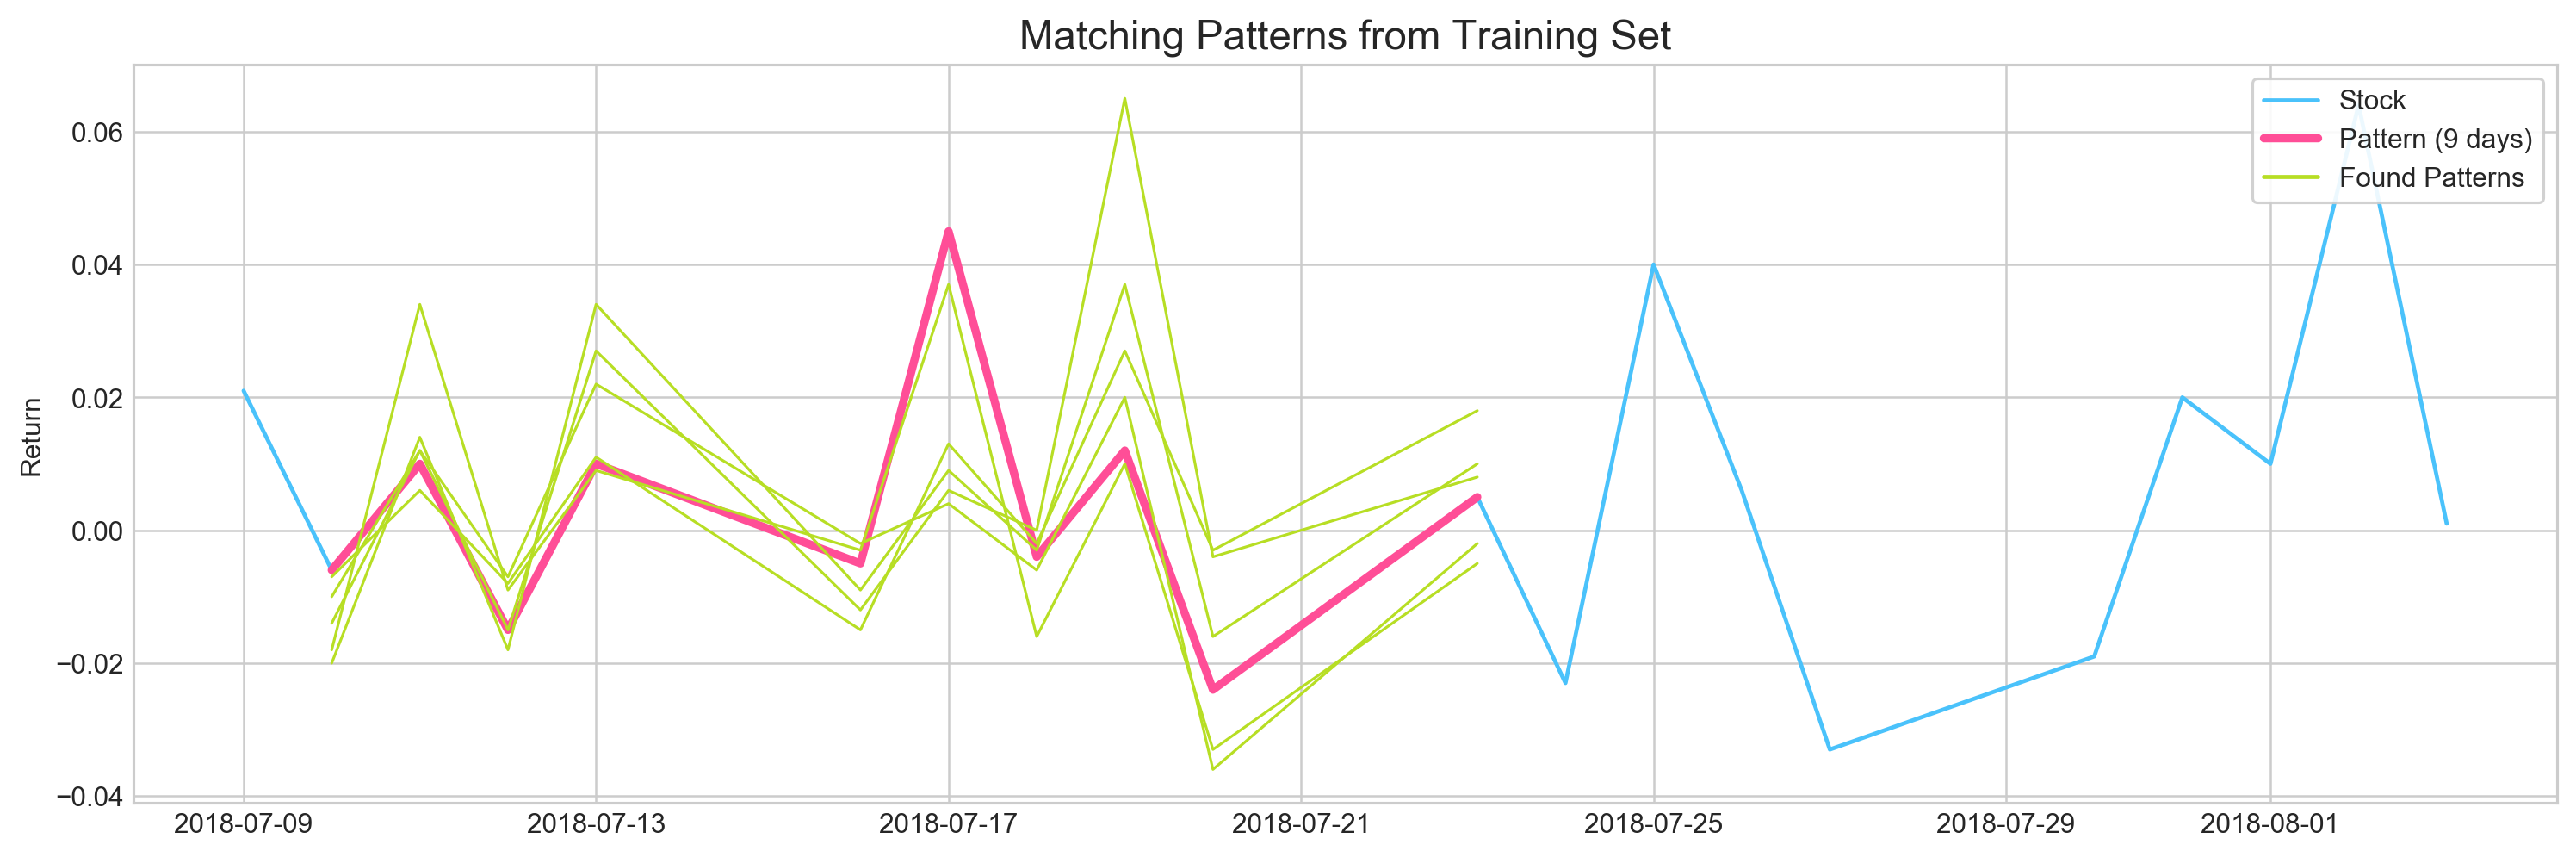

In [556]:
indexes = stocks['tsla'][2001:2011].Return.index

plt.figure(figsize=(16,5))
plt.plot(stocks['tsla'][2000:2020].Return, label='Stock', c='#4ac2fb')
plt.plot(stocks['tsla'][2001:2011].Return, lw=3, label='Pattern (9 days)', c='#ff4e97')

for i in a:
    plt.plot(stocks['tsla'][i:i+10].set_index(indexes).Return, lw=1, c='#b7de24')

plt.plot([],[], label='Found Patterns', c='#b7de24') # dummy plot for legend

plt.legend(frameon=True, fancybox=True, framealpha=.9, loc=1)
plt.title('Matching Patterns from Training Set', fontSize=15)
plt.ylabel('Return')
plt.show()

# Q-Learning

## MACD

Number of Trades: 35
Time Frame: 718 days
Profit: $4246.46 | 28.31%


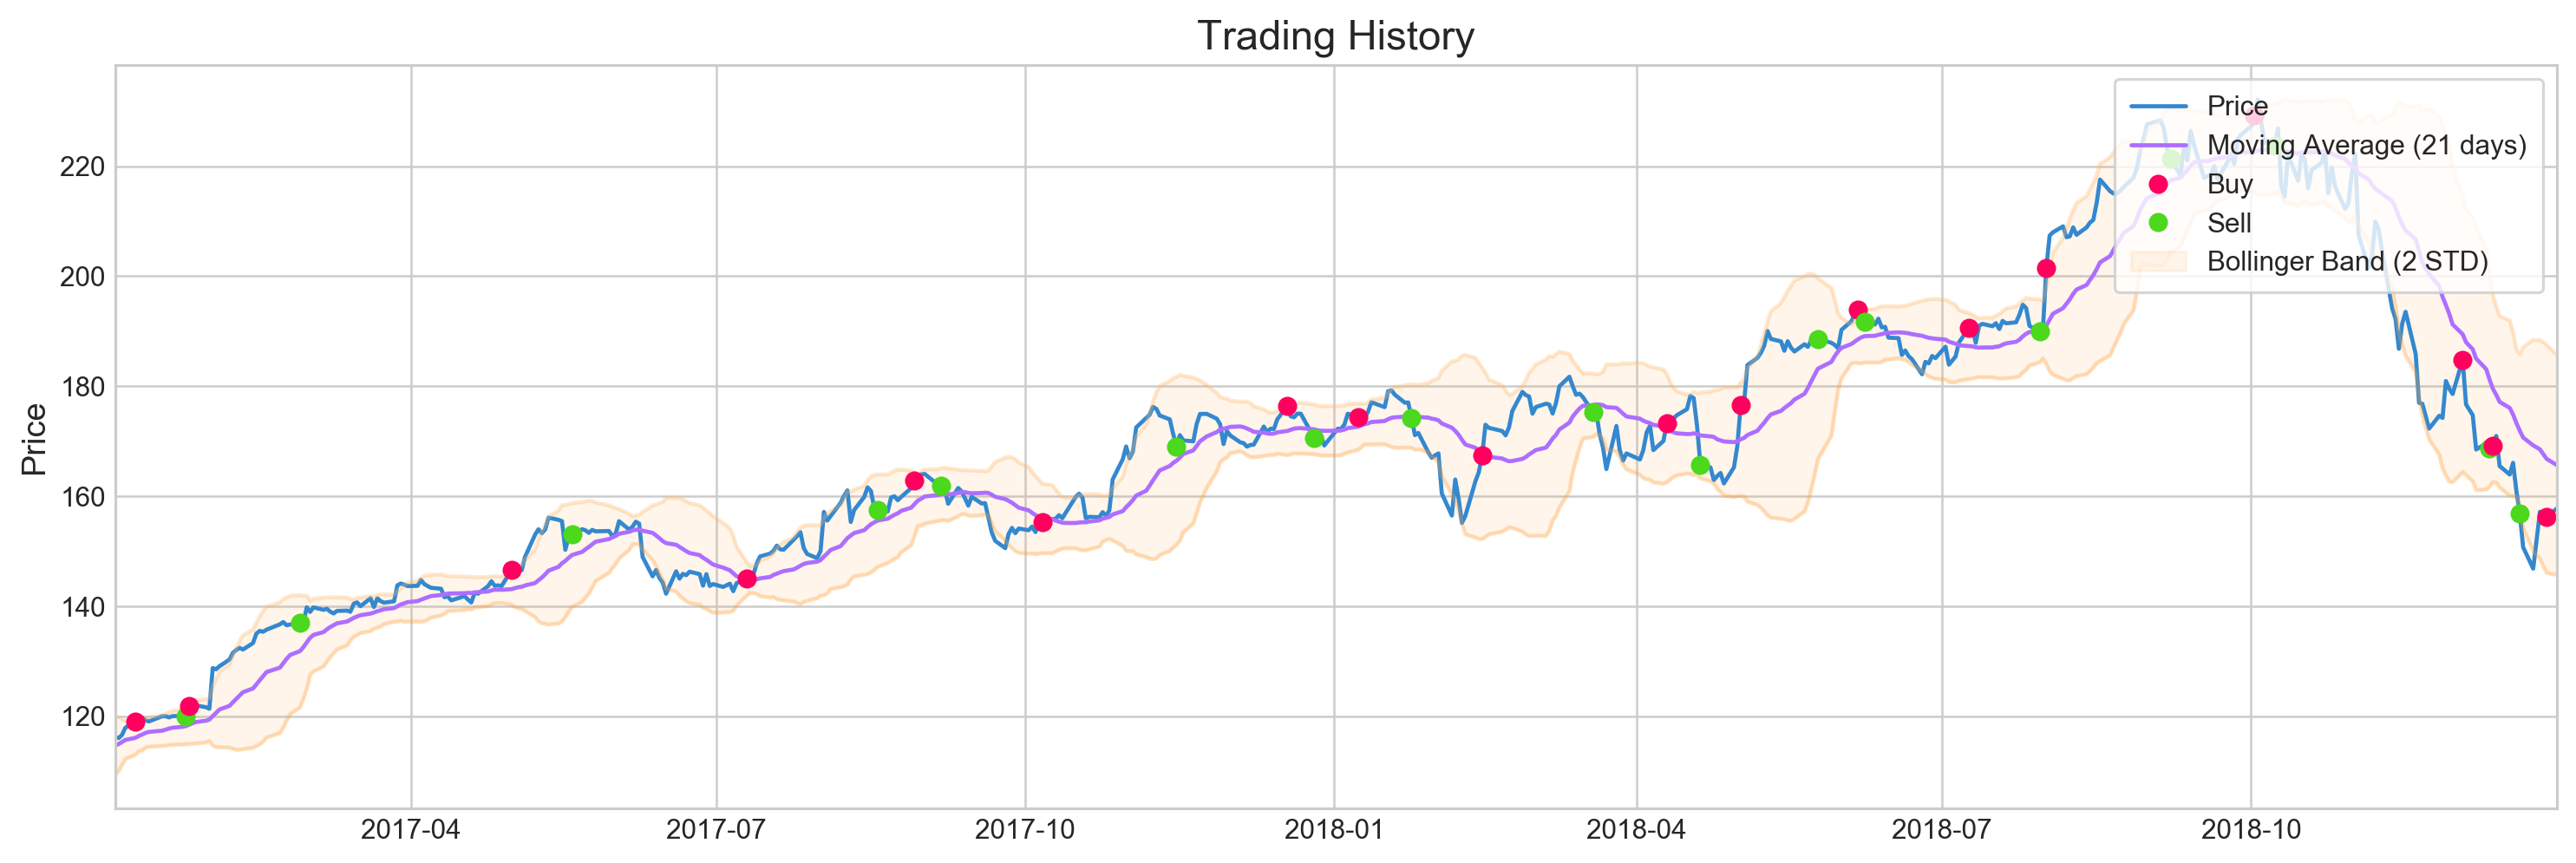

In [2401]:
profit, net = functions.macd_trading(stocks['aapl'].loc['2017':'2018'])

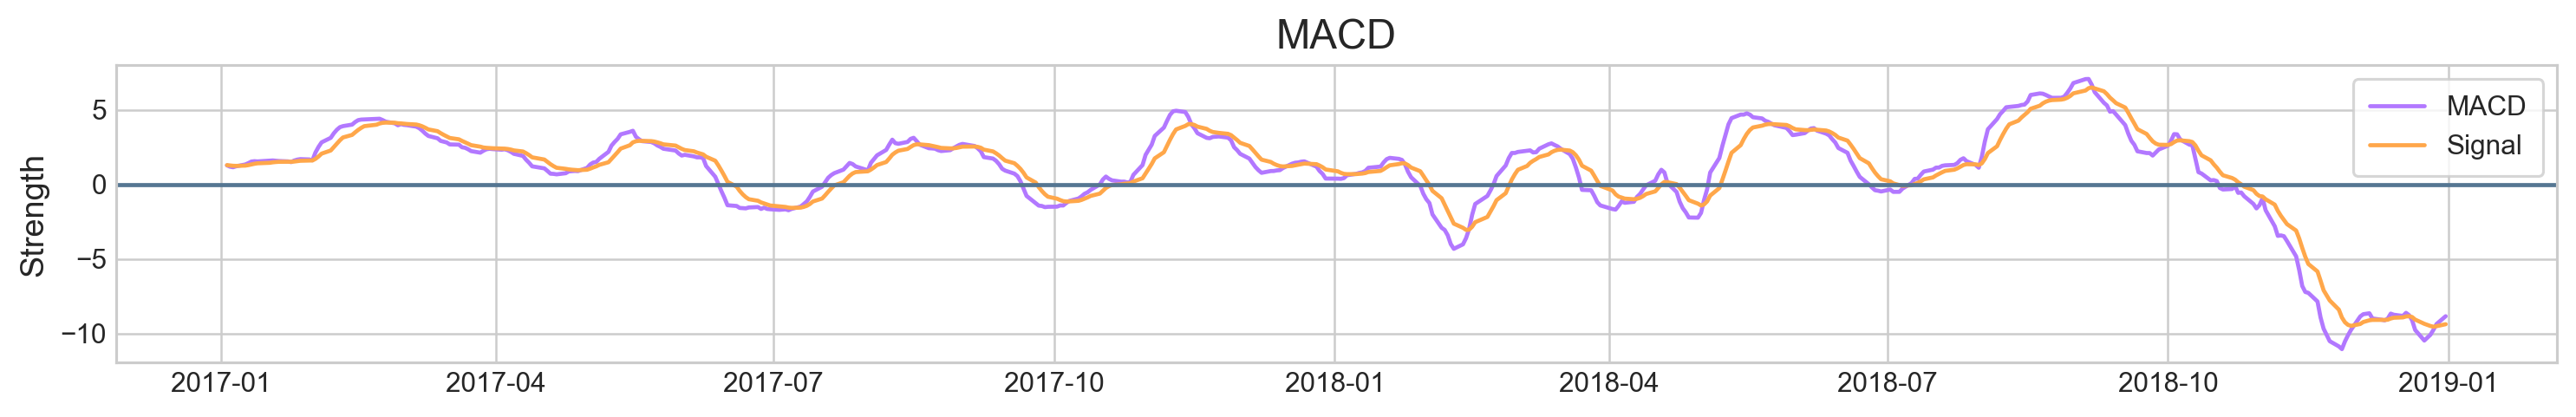

In [2397]:
plotting.macd(stocks['aapl'].loc['2017':'2018'])

## Bollinger Bands

Number of Trades: 27
Time Frame: 570 days
Profit: $3781.45 | 25.21%


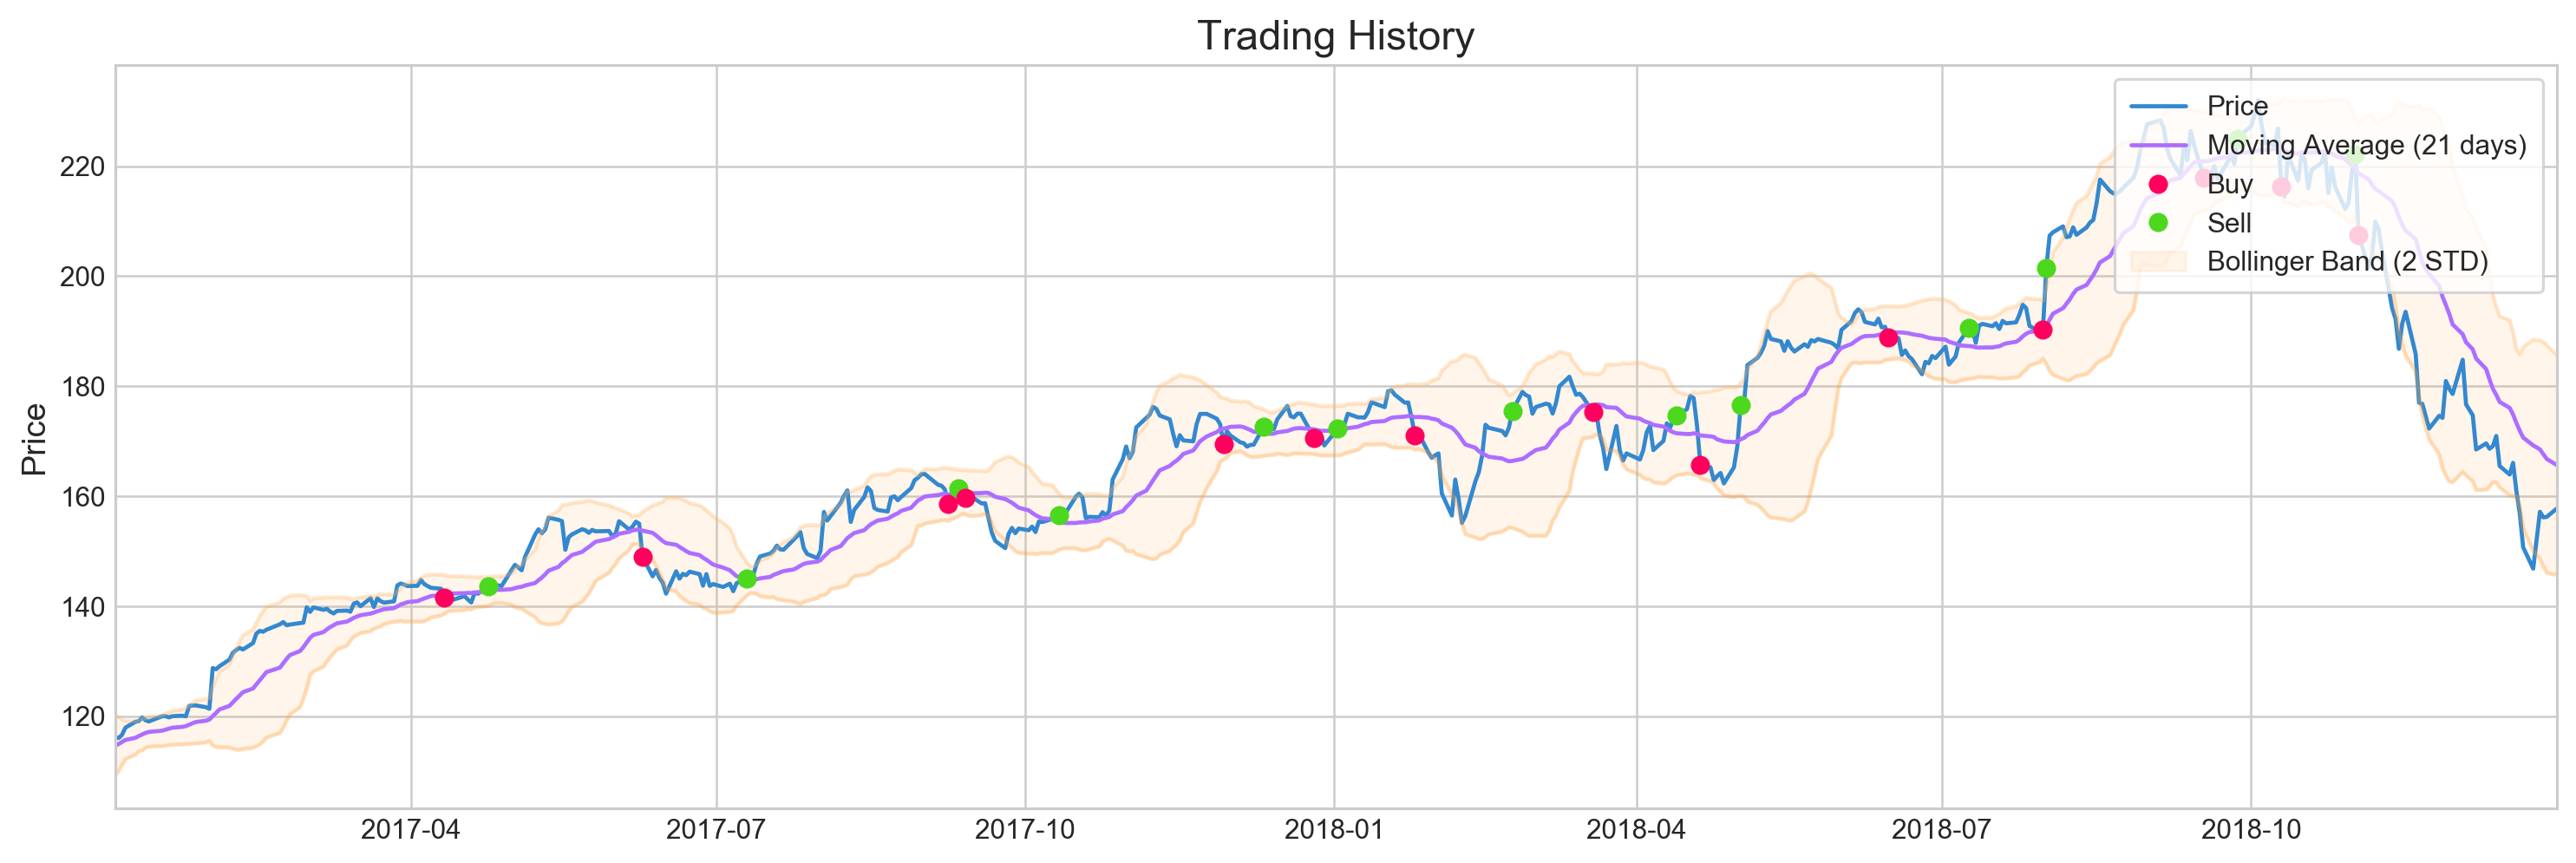

In [2402]:
profit, net = functions.bb_trading(stocks['aapl'].loc['2017':'2018'], u=0.03, l=0.03)

# Conclusion